This notebook compares the results of genome-wide boundary CTCF perturbations with DNA sequence.

First, results are loaded from h5 and filtered based on whether a given boundary was responsive to CTCF motif mutagenesis.

Sites are further filtered by jaspar CTCF score.

Sequences around each site are loaded and visualized.

The TGCAxTTC motif is visible by eye in strong sequences, but only appears in ~1/4 of sequences.

In [1]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import h5py
import os
from scipy.stats import spearmanr, pearsonr
import scipy.cluster
import pysam

from matplotlib import colors
cmap_purple_green_GC = colors.ListedColormap([ 
    'mistyrose', #a 
    'darkseagreen', #c
    'plum', #g
    'beige' #t
])
cmap_rhee = colors.ListedColormap([
    'red', #a red
    'blue', #c blue
    'yellow', #g yllow
    'green' #t green
])

cmaps = [cmap_purple_green_GC, cmap_rhee]


In [2]:
import akita_utils
# from akita_utils.utils import h5_to_df, filter_by_chrmlen, dna_1hot, dna_1hot_index, dna_1hot_GC, dna_rc

### Load & filter genomic deletion SCD for boundary CTCFs

In [3]:
df = akita_utils.tsv_gen_utils.filter_boundary_ctcfs_from_h5(
    h5_dirs="/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model*/scd.h5",
    score_key="SCD",
    threshold_all_ctcf=5,
)


annotating each site with boundary-wide scores


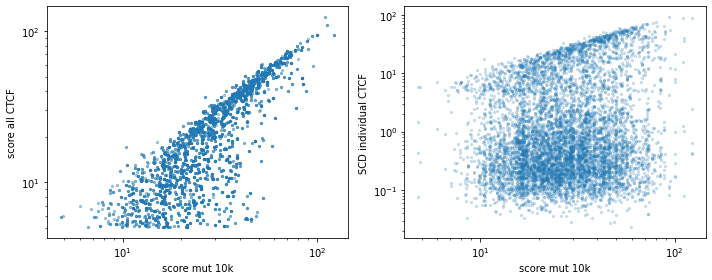

In [4]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.scatter(df['score_10k'],df['score_all_ctcf'], 5, alpha=0.2)
plt.loglog()
plt.xlabel('score mut 10k')
plt.ylabel('score all CTCF')

plt.subplot(122)
plt.scatter(df['score_10k'],df['SCD'], 5, alpha=0.2)
plt.loglog()
plt.xlabel('score mut 10k')
plt.ylabel('SCD individual CTCF')
plt.tight_layout()

In [5]:
# filter by rmsk
sites = akita_utils.filter_by_rmsk(df) 

## add scores for jaspar core motif to table of sites
ctcf_motifs = bioframe.read_table('/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz',
                                  schema="jaspar", skiprows=1)
sites = sites.merge(ctcf_motifs, how='left', 
                    left_on= ['chrom','start_2','end_2'], right_on=['chrom','start','end'])

sites_unfiltered = sites.copy()

filtering sites by overlap with rmsk


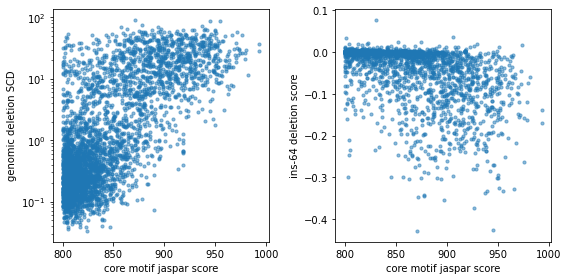

In [6]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter( sites['score'], sites['SCD'], 10, alpha=0.5)
plt.semilogy()
plt.xlabel('core motif jaspar score')
plt.ylabel('genomic deletion SCD')

plt.subplot(122)
plt.scatter( sites['score'], sites['INS-64'], 10, alpha=0.5)
plt.xlabel('core motif jaspar score')
plt.ylabel('ins-64 deletion score')

plt.tight_layout()

In [7]:
## get sites with similar core motif strengths 
#sites = sites.query('(score > 800) and (score < 850)')

sites = sites_unfiltered.query('(score > 825) and (score < 875)').copy()
sites.reset_index(drop=True, inplace=True)

In [8]:
## split sites by strong vs weak, here using insulation score (ins-64)
sites_weak = sites['INS-64'].values > -.01
sites_strong = sites['INS-64'].values < -.03

sites_weak = np.where(sites_weak)[0]
sites_strong = np.where(sites_strong)[0]
print('num weak',len(sites_weak), ', num strong',len(sites_strong))

num_sites = 200
sites_weak = sites_weak[np.sort(
    np.random.choice(len(sites_weak),num_sites,replace=False)
)]
sites_strong = sites_strong[np.sort(
    np.random.choice(len(sites_strong),num_sites,replace=False)
)]
sites_strong = sites.loc[sites_strong].reset_index(drop=True)
sites_weak = sites.loc[sites_weak].reset_index(drop=True)


num weak 805 , num strong 222


In [11]:
def get_seqs(sites, genome_file='/project/fudenber_735/genomes/mm10/mm10.fa', extent_bp=100, verbose=False):
    """
    Get and orient DNA sequence around motifs, and return arrays with various transformation:
    into 1hot, index, and binary (GC). 
    """
    genome_open = pysam.Fastafile(genome_file)

    seqs=[]
    seqs_1hot = []
    seqs_index=[]
    seqs_GC =[]
    for i in range(len(sites)):
        if verbose: 
            if np.mod(i, 50)==0: print(i)
        chrm, start, end, strand = sites.loc[i][['chrom','start_2','end_2','strand_2']]
        start = start-extent_bp
        end = end+extent_bp
        seq =  genome_open.fetch(chrm, start, end).upper()
        if strand == '-':
            seq = akita_utils.dna_utils.dna_rc(seq)
        seqs.append(seq)
        seqs_1hot.append(akita_utils.dna_utils.dna_1hot(seq))
        seqs_index.append( akita_utils.dna_utils.dna_1hot_index(seq))
        seqs_GC.append( akita_utils.dna_utils.dna_1hot_GC(seq))
    seqs_index = np.array(seqs_index)
    seqs_GC = np.array(seqs_GC)
    seqs_1hot  = np.array(seqs_1hot)
    return seqs, seqs_1hot, seqs_index, seqs_GC


In [12]:
seqs_weak, seqs_1hot_weak, seqs_index_weak, seqs_GC_weak = get_seqs(sites_weak, genome_file='/project/fudenber_735/genomes/mm10/mm10.fa', extent_bp=100)
seqs_strong, seqs_1hot_strong, seqs_index_strong, seqs_GC_strong = get_seqs(sites_strong, genome_file='/project/fudenber_735/genomes/mm10/mm10.fa', extent_bp=100)

In [13]:
def reorder_by_hamming( seqs_index, sub_index= (80,100), verbose=False):
    """
    Reorders a set of index-encoded (A=0,C=1,G=2,T=3) DNA sequences by their similarity.
    Similarity is computedb by hamming distance for all nucleotides between 
    sub_index[0]:sub_index[1].
    
    Returns
    --------
    reordering : np.array
        Array specifying reordering for sites.
        
    """
    
    if not (np.unique(seqs_index) == np.arange(4).astype(int)).all():
        raise ValueError('must input a 1-hot encoded DNA sequence')
    
    if sub_index is None:
        sub_index = (0, seqs_index.shape[1])

    seq_dist = np.zeros((seqs_index.shape[0], seqs_index.shape[0]))
    for i in range(len(seqs_index)):
        if verbose:
            if np.mod(i,100)==0: print(i)
        seq_i = seqs_index[i][sub_index[0]:sub_index[1]]
        for j in range(len(seqs_index)):
            if i<j:
                seq_j = seqs_index[j][sub_index[0]:sub_index[1]]
                seq_dist[i,j] = 1 - scipy.spatial.distance.hamming(seq_i, seq_j)
    seq_dist = seq_dist  + seq_dist.T        
    reordering = scipy.cluster.hierarchy.leaves_list(
                    scipy.cluster.hierarchy.linkage( seq_dist)
    )
    return reordering

In [14]:
#reorder_bp = (120,140) # when extend_bp above is 100 this corresponds to organizing by sequence after the motif
reorder_bp = (80, 100) #this corresponds to reordering based on sequence just before the motif
reordering = 'hamming'
if reordering == 'hamming':
    strong_reordering = reorder_by_hamming( seqs_index_strong, sub_index= reorder_bp)
    weak_reordering   = reorder_by_hamming( seqs_index_weak, sub_index= reorder_bp)
elif reordering == 'GC':
    strong_reordering = np.argsort(
                        np.sum(seqs_GC_strong[:,reorder_bp[0]:reorder_bp[1]],axis=1))
    weak_reordering= np.argsort(
                        np.sum(seqs_GC_weak[:,reorder_bp[0]:reorder_bp[1]],axis=1))    
else:
    raise ValueError('must specifying a reordering')


/tmp/SLURM_10187047/ipykernel_62121/3039778477.py:31: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  scipy.cluster.hierarchy.linkage( seq_dist)


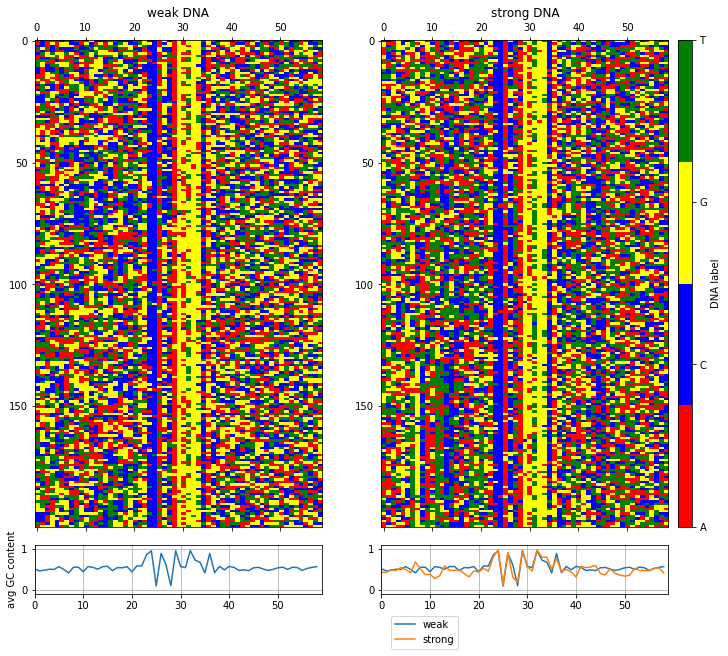

In [15]:
#bp_start,bp_stop = 80,100
#bp_start,bp_stop = 120,140#,100

extend_bp = 20
bp_start,bp_stop = 100-extend_bp,119+extend_bp
cmap = cmaps[1]

plt_width=4
f, axs = plt.subplots(
    figsize=( plt_width+plt_width+2, plt_width+plt_width+1),
    ncols=4,
    nrows=2,
    gridspec_kw={
        'height_ratios':[10,1],
         "wspace":0.01,
        'width_ratios':[1, .05, 1, .05]},
    constrained_layout=True
)

ax = axs[0,0]
im = ax.matshow(
    seqs_index_weak[:,bp_start:bp_stop][weak_reordering],  
    cmap=cmap,
   )
ax.set_title('weak DNA')
ax.set_aspect('auto')

ax = axs[0,2]
im = ax.matshow(
    seqs_index_strong[:,bp_start:bp_stop][strong_reordering],  
    cmap=cmap,
   )
ax.set_title('strong DNA')
ax.set_aspect('auto')

cax = axs[0,3]
cbar = plt.colorbar(im, cax=cax, label='DNA label', ticks= np.arange(4))
cbar.ax.set_yticklabels(['A','C','G','T']);

ax = axs[1,0]
ax.plot(np.mean(seqs_GC_weak[:,bp_start:bp_stop],axis=0))
ax.set_ylim([-.1,1.1])
ax.grid(True)
ax.set_xlim([0, bp_stop-bp_start])
ax.set_ylabel('avg GC content')

ax = axs[1,2]
ax.plot(np.mean(seqs_GC_weak[:,bp_start:bp_stop],axis=0), label='weak')
ax.plot(np.mean(seqs_GC_strong[:,bp_start:bp_stop],axis=0),label='strong')
ax.set_ylim([-.1,1.1])
ax.grid(True)
ax.set_xlim([0, bp_stop-bp_start])
ax.legend(loc='upper center', bbox_to_anchor=(0.15, -0.35))
        
ax = axs[1,1]
ax.set_visible(False)
ax = axs[0,1]
ax.set_visible(False)
ax = axs[1,3]
ax.set_visible(False)

plt.show()
